<center><h1> Perception Task 1 (b) </h1></center> 

## Import Packages

In [1]:
import numpy as np # To be able to handle arrays
import pandas as pd # To use dataframes
from keras_preprocessing.image import ImageDataGenerator, load_img # To load images, make image processing
from sklearn.model_selection import train_test_split # To split the data, to be able to check the val accuracy
import matplotlib.pyplot as plt # To plot images
import os # To access directory files
from keras.models import Sequential # To use nerual networks
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization # To use CNN and ANN

In [2]:
# Enter data path
PATH = "A:\Professional\Student Activities\Formula\Perception Interview Task\Dogs_vs_Cats_Classification\data"
print(os.listdir(PATH))

['test', 'train']


- Our data Directory:
    - train (1,363 items)
        - dog.21.jpg, cat.08.jpg,....
    - test (36 items)
        - dog.11.jpg, cat.01.jpg,....

## Preprocessing

In [3]:
# As our data is classifed by dog/cat name plus a number,
# then we can make use of this assigning each dog/cat category into a dataframe along with the name ofeach image
train_data = os.listdir(f"{PATH}\\train")
categories = []
for data in train_data:
    category = data.split('.')[0]
    if category == 'dog':
        categories.append("dog") # We can assign strings and our ImageGenerators will assign them as categories 
    else:
        categories.append("cat")

train_df = pd.DataFrame({
    'path': train_data,
    'category': categories
})

In [4]:
# The test dataframe at which we will test our model with
test_data = os.listdir(f"{PATH}\\test")
categories = []
for data in test_data:
    category = data.split('.')[0]
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')

test_df = pd.DataFrame({
    'path': test_data,
    'category': categories
})

In [5]:
train_df.head()

,path,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [6]:
test_df.tail()

,path,category
31,dog.5.jpg,dog
32,dog.6.jpg,dog
33,dog.7.jpg,dog
34,dog.8.jpg,dog
35,dog.9.jpg,dog


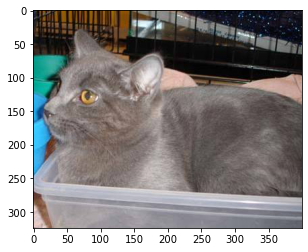

In [7]:
# A trial to detect if all our data is clean
image = load_img(f"{PATH}\\test\\{test_data[0]}")
plt.imshow(image)

In [8]:
# To check validation accuracy vs model accuracy 
train_data, val_data = train_test_split(train_df, test_size=0.20, random_state=42)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

In [9]:
# Constants
batch_size=15
epochs = 12
IMAGE_WIDTH=120
IMAGE_HEIGHT=120
Image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
total_train = train_data.shape[0]
total_val = val_data.shape[0]

In [10]:
# Generator for our training data
# This help to reduce overfitting
train_data_generator = ImageDataGenerator(rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,                                       
    )
# Generator for our validation data
# We do not want our validation data to be mess
validation_data_generator = ImageDataGenerator(rescale = 1./255)

In [11]:
train_generator = train_data_generator.flow_from_dataframe(
    train_data, 
    f"{PATH}\\train", 
    x_col='path',
    y_col='category',
    target_size=Image_size,
    class_mode='categorical', # Convert Strings into Numbers 
    batch_size=batch_size,
)

validation_generator = validation_data_generator.flow_from_dataframe(
    val_data,
    f"{PATH}\\train",
    x_col='path',
    y_col='category',
    target_size=Image_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1090 validated image filenames belonging to 2 classes.
Found 273 validated image filenames belonging to 2 classes.


In [12]:
# This help to reduce overfitting
test_data_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15, 
    shear_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.1, 
    height_shift_range = 0.1)

test_generator = test_data_generator.flow_from_dataframe(
    test_df, 
    f"{PATH}\\test", 
    x_col='path',
    y_col=None,
    target_size=Image_size,
    class_mode=None,
    batch_size=batch_size,
    shuffle=False)

Found 36 validated image filenames.


Plot Sample of images

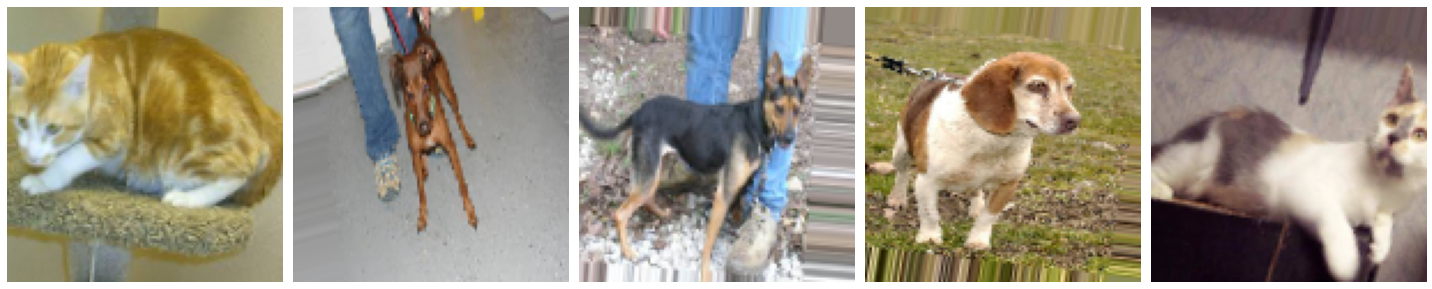

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [13]:
sample_training_images, _ = next(train_generator)
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:5])
_[:5]

We notice that cats are category `0` and dogs are category `1`

## Deep Learning Model

In [14]:
# Create Neural Network
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))) # CNN
model.add(BatchNormalization()) # To prevent overfitting
model.add(MaxPooling2D(pool_size=(2, 2))) # To get the most effective data
model.add(Dropout(0.25)) # To prevent overfitting

model.add(Conv2D(64, (3, 3), activation='relu')) # The relu to discard negative pixels
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu')) # Filters with size 3*3
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

In [15]:
# Compile our model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 118, 118, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 59, 59, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 57, 57, 64)       2

In [16]:
# Create efficient callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10) # Earlystopping prevents the overfitting
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', # Learning rate reduction reduce the learning rate
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [17]:
# Train our model
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_val//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-17-731620a5c869>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/12
72/72 [==============================] - 39s 472ms/step - loss: 1.3980 - accuracy: 0.5721 - val_loss: 0.8940 - val_accuracy: 0.4741 - lr: 0.0010
Epoch 2/12
72/72 [==============================] - 35s 481ms/step - loss: 1.0597 - accuracy: 0.5824 - val_loss: 5.1772 - val_accuracy: 0.5259 - lr: 0.0010
Epoch 3/12
72/72 [==============================] - 34s 472ms/step - loss: 0.9183 - accuracy: 0.5898 - val_loss: 2.7421 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 4/12
72/72 [==============================] - 33s 462ms/step - loss: 0.8145 - accuracy: 0.6307 - val_loss: 1.3993 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 5/12
72/72 [==============================] - 34s 465ms/step - loss: 0.7443 - accuracy: 0.6417 - val_loss: 1.5093 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 6/12
72/72 [==============================] - 33s 461ms/step - loss: 0.6983 - accuracy: 0.6512 - val_loss: 1.0091 - val_accuracy: 0.5370 - lr: 0.0010
Epoch 7/12
72/72 [==============================] - 19s 255ms/st

In [18]:
model.save_weights("./image_model.h5")

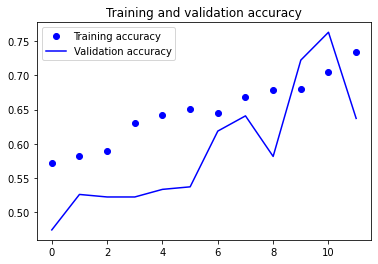

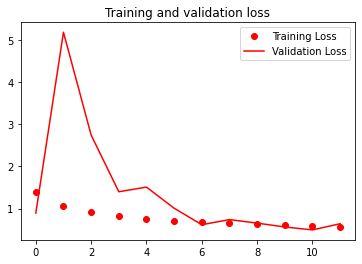

In [19]:
# Plot our training accuracy/loss vs val accuracy/loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoches = range(len(acc))

plt.plot(epoches, acc, 'bo', label='Training accuracy')
plt.plot(epoches, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epoches, loss, 'ro', label='Training Loss')
plt.plot(epoches, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

- We notice that this image-based model inspite of all what we did. it reduced overfitting. 
- So, it is really advisable to work with image-based model.
- We reached training accuracy of `73%` and validation accracy of `63` and even we could achieve to more better result by checking the previous plot

## Make Predictions

In [20]:
prediction = model.predict(test_generator, steps=np.ceil(test_df.shape[0]/batch_size))
preds_classes = np.argmax(prediction, axis=-1)
preds_classes

3/3 [==============================] - 0s 60ms/step


array([0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], dtype=int64)

Real value:
dog

Predicted value:
dog


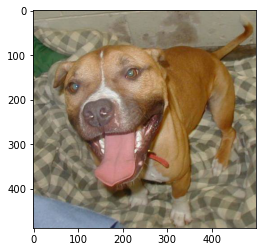

In [29]:
test_img = test_df.sample()
img = load_img(f"{PATH}\\test\\{(test_img['path'].values[0])}")
plt.imshow(img)
print(f"Real value:\n{test_img['path'].values[0].split('.')[0]}\n")

predicted_value = ''
if preds_classes[test_img.index.values[0]] == 1:
    predicted_value = 'dog'
else:
    predicted_value = 'cat'

print(f"Predicted value:\n{predicted_value}")